# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. 

Данные для работы - это исторические данные: технические характеристики, комплектации и цены автомобилей. 

Цель работы: построение модели для определения стоимости.

Критерии задазчика по модели:
- высокое качество предсказания, 
- скорость предстазания, 
- время обучения.

Для реализации необходимо выполнить ряд задач:
1. Загрузить данные, путь к файлу: /datasets/autos.csv.
2. Изучить данные. Заполнить пропущенные значения и обработайть аномалии в столбцах. Если среди признаков имеются неинформативные, удалить их.
3. Подготовьть выборки для обучения моделей.
4. Обучить разные модели, одна из которых — LightGBM, как минимум одна — не бустинг. Для каждой модели попробывать разные гиперпараметры.
5. Проанализировать время обучения, время предсказания и качество моделей.
6. Опираясь на критерии заказчика, выбрать лучшую модель, проверить её качество на тестовой выборке.

Примечание:
1. Для оценки качества моделей применить метрику RMSE.
2. Значение метрики RMSE должно быть меньше 2500.

Данные хранятся в файле /datasets/autos.csv

Описание признаков:
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

In [1]:
!pip -q install phik

In [2]:
!pip install --upgrade scikit-learn

In [3]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [4]:
import sklearn
from sklearn import svm
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split,cross_val_score,RandomizedSearchCV,GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler,OneHotEncoder,OrdinalEncoder,RobustScaler,TargetEncoder
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.impute import SimpleImputer

RANDOM_STATE = 42
TEST_SIZE = 0.4

In [5]:
from phik import phik_matrix

In [6]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

## Подготовка данных

### Первое знакомство с данными
На данном этапе необходимо загрузить данные, вывести пару строк на экран и получить общую информацию о данных. После сделать выводы по поводу предобработки данных.

In [7]:
data = pd.read_csv('/datasets/autos.csv')

In [8]:
display(data.head(5))

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [9]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

#### ВЫВОД :
После выгрузки данных и получения их общей информации было установлено, что в предобрабоке необходимо сделать:
1. Исправить название колонн, заменить все буквы на строчные, вместо пробелов "_" ;
2. Исправить типы данных, где они установлены некорректно, а именно у DateCrawled, RegistrationMonth,DateCreated, LastSeen.
3. Посмотреть все данные на пропуски и дубликаты.

### ПРЕДОБРБОТКА ДАННЫХ 
На основе вывода из п.1 сделать неободимую предобработку данных.

In [10]:
data.set_axis(['Date_Crawled', 'Price', 'Vehicle_Type', 'Registration_Year', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'Registration_Month', 'Fuel_Type', 'Brand',
       'Repaired', 'Date_Created', 'Number_Of_Pictures', 'Postal_Code',
       'Last_Seen'], axis="columns", inplace=True) 
data.columns = data.columns.str.lower()

In [11]:
data.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

In [12]:
print('Количество дубликотов строк в data :',data.duplicated().sum())
print ('Процент дубликатов строк от всего количества строк',round(data.duplicated().sum() / data.shape[0]* 100,3))
print('Количество строк :',data.shape[0])

Количество дубликотов строк в data : 4
Процент дубликатов строк от всего количества строк 0.001
Количество строк : 354369


In [13]:
data = data.drop_duplicates()
data = data.reset_index(drop = True)


In [14]:
print(data.shape[0])#проверка строк, первоначально:354369

354365


In [15]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354365 entries, 0 to 354364
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354365 non-null  object
 1   price               354365 non-null  int64 
 2   vehicle_type        316875 non-null  object
 3   registration_year   354365 non-null  int64 
 4   gearbox             334532 non-null  object
 5   power               354365 non-null  int64 
 6   model               334660 non-null  object
 7   kilometer           354365 non-null  int64 
 8   registration_month  354365 non-null  int64 
 9   fuel_type           321470 non-null  object
 10  brand               354365 non-null  object
 11  repaired            283211 non-null  object
 12  date_created        354365 non-null  object
 13  number_of_pictures  354365 non-null  int64 
 14  postal_code         354365 non-null  int64 
 15  last_seen           354365 non-null  object
dtypes:

In [16]:
print(data.isna().sum())

date_crawled              0
price                     0
vehicle_type          37490
registration_year         0
gearbox               19833
power                     0
model                 19705
kilometer                 0
registration_month        0
fuel_type             32895
brand                     0
repaired              71154
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
dtype: int64


In [17]:
print ('уникальные значения столбца vehicle_type :',data['vehicle_type'].unique())

уникальные значения столбца vehicle_type : [nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']


In [18]:
data['vehicle_type'] = data['vehicle_type'].fillna('other')

In [19]:
print ('уникальные значения столбца vehicle_type :',data['vehicle_type'].unique())

уникальные значения столбца vehicle_type : ['other' 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon']


In [20]:
print ('уникальные значения столбца gearbox :',data['gearbox'].unique())

уникальные значения столбца gearbox : ['manual' 'auto' nan]


In [21]:
data['gearbox'] = data['gearbox'].fillna('unknown')

In [22]:
print ('уникальные значения столбца gearbox :',data['gearbox'].unique())

уникальные значения столбца gearbox : ['manual' 'auto' 'unknown']


In [23]:
print ('уникальные значения столбца fuel_type :',data['fuel_type'].unique())

уникальные значения столбца fuel_type : ['petrol' 'gasoline' nan 'lpg' 'other' 'hybrid' 'cng' 'electric']


In [24]:
data['fuel_type'] = data['fuel_type'].str.replace('lpg','gas').replace('cng' ,'gas').replace('gasoline' ,'petrol')

In [25]:
data['fuel_type'] = data['fuel_type'].fillna('other')

In [26]:
print ('уникальные значения столбца fuel_type :',data['fuel_type'].unique())

уникальные значения столбца fuel_type : ['petrol' 'other' 'gas' 'hybrid' 'electric']


In [27]:
print ('уникальные значения столбца model :',data['model'].unique())

уникальные значения столбца model : ['golf' nan 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max' '3_reihe'
 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er'
 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio'
 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_reihe' 'yeti' 'octavia' 'mii'
 'rx_reihe' '6er' 'modus' 'fox' 'matiz' 'beetle' 'c1' 'rio' 'touareg'
 'logan' 'spider' 'cuore' 's_max' 'a2' 'galaxy' 'c3' 'viano' 's_klasse'
 '1_reihe' 'avensis' 'roomster' 'sl' 

In [28]:
data['model'] = data['model'].fillna('other')

In [29]:
print ('уникальные значения столбца brand :',data['brand'].unique())

уникальные значения столбца brand : ['volkswagen' 'audi' 'jeep' 'skoda' 'bmw' 'peugeot' 'ford' 'mazda'
 'nissan' 'renault' 'mercedes_benz' 'opel' 'seat' 'citroen' 'honda' 'fiat'
 'mini' 'smart' 'hyundai' 'sonstige_autos' 'alfa_romeo' 'subaru' 'volvo'
 'mitsubishi' 'kia' 'suzuki' 'lancia' 'toyota' 'chevrolet' 'dacia'
 'daihatsu' 'trabant' 'saab' 'chrysler' 'jaguar' 'daewoo' 'porsche'
 'rover' 'land_rover' 'lada']


In [30]:
print ('уникальные значения столбца repaired :',data['repaired'].unique())

уникальные значения столбца repaired : [nan 'yes' 'no']


In [31]:
data['repaired'] = data['repaired'].fillna('unknown')

In [32]:
print ('уникальные значения столбца repaired :',data['repaired'].unique())

уникальные значения столбца repaired : ['unknown' 'yes' 'no']


In [33]:
print(data.isna().sum())

date_crawled          0
price                 0
vehicle_type          0
registration_year     0
gearbox               0
power                 0
model                 0
kilometer             0
registration_month    0
fuel_type             0
brand                 0
repaired              0
date_created          0
number_of_pictures    0
postal_code           0
last_seen             0
dtype: int64


In [34]:
data = data.drop([
    'date_crawled',
    'registration_month',
    'number_of_pictures',
    'last_seen',
    'date_created',
    'postal_code'
], axis=1)

In [35]:
display(data.head(5))

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,480,other,1993,manual,0,golf,150000,petrol,volkswagen,unknown
1,18300,coupe,2011,manual,190,other,125000,petrol,audi,yes
2,9800,suv,2004,auto,163,grand,125000,petrol,jeep,unknown
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,petrol,skoda,no


#### ВЫВОД: в предобработку данных было выполнено:
1. удалены столбцы 'date_crawled','registration_month','number_of_pictures','last_seen','date_created','postal_code'. Поскольку информация в них является лишней для нашей задачи.
2. были удалены дубликаты, их было 4.
3. была проведена замена пропусков, в основном пропуски были заменены на 'other' и 'unknown'.

### ИССЛЕДОВАТЕЛЬСКИЙ И КОРРЕЛЯЦИОННЫЙ АНАЛИЗЫ ДАННЫХ

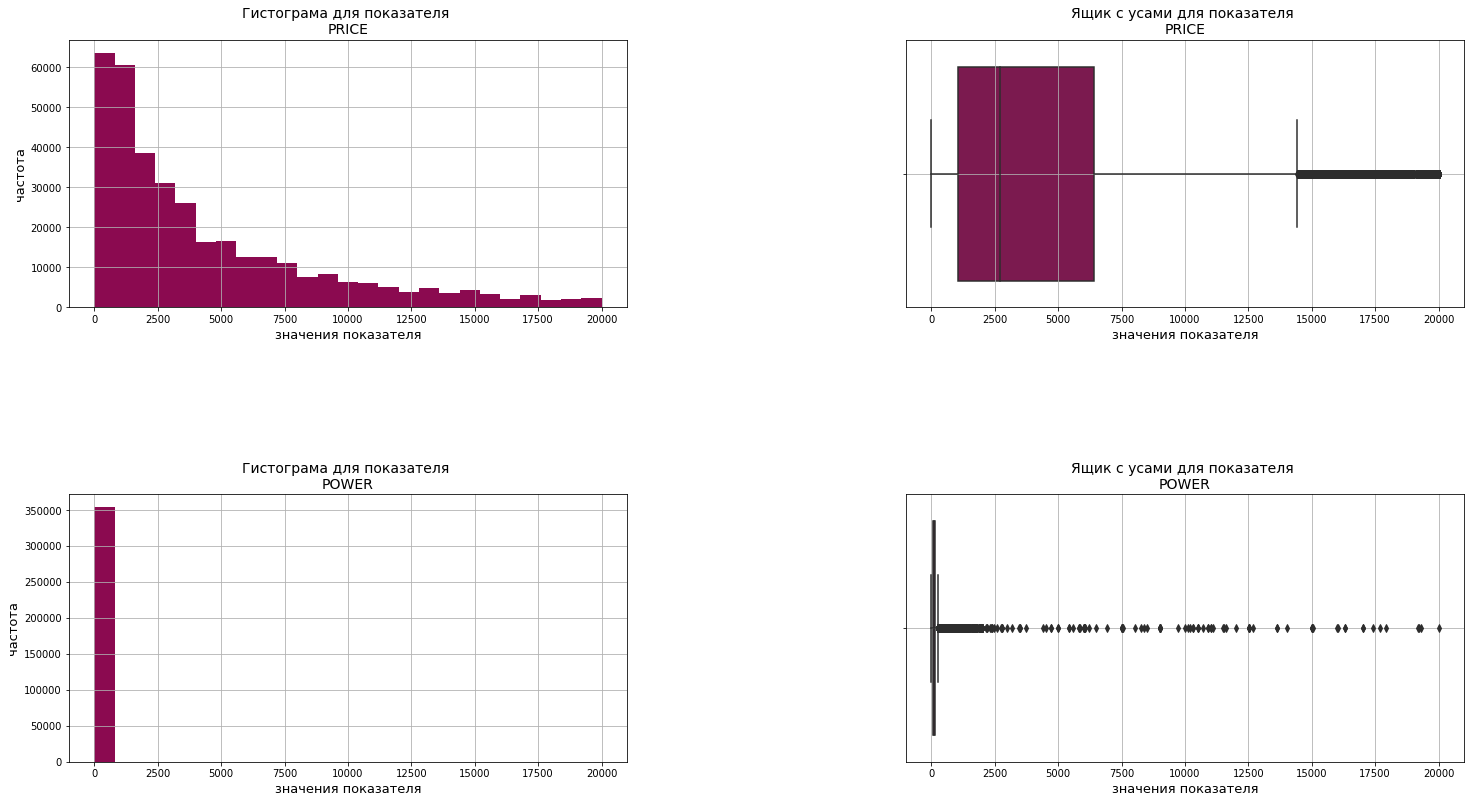

In [36]:
position = 0
plt.figure(figsize=[25,30])
plt.subplots_adjust(wspace=0.5, hspace=0.7)

list = [ 
    'price',
    'power'
]

for name in list:
    position += 1
    
    df1 = data[name]
    plt.subplot(4, 2, position)
    df1.plot(kind = 'hist', color = '#8B0A50', bins = 25)
    plt.title(f'Гистограма для показателя \n{name.upper()}', fontsize=14)
    plt.xlabel('значения показателя', fontsize=13)
    plt.ylabel('частота', fontsize=13)
    plt.grid(True)
    
    position += 1
    df2 = data[name]
    plt.subplot(4, 2, position)
    sns.boxplot(x= df2,color = '#8B0A50')
    plt.title(f'Ящик с усами для показателя \n{name.upper()}', fontsize=14)
    plt.xlabel('значения показателя',fontsize=13 )
    plt.grid(True);

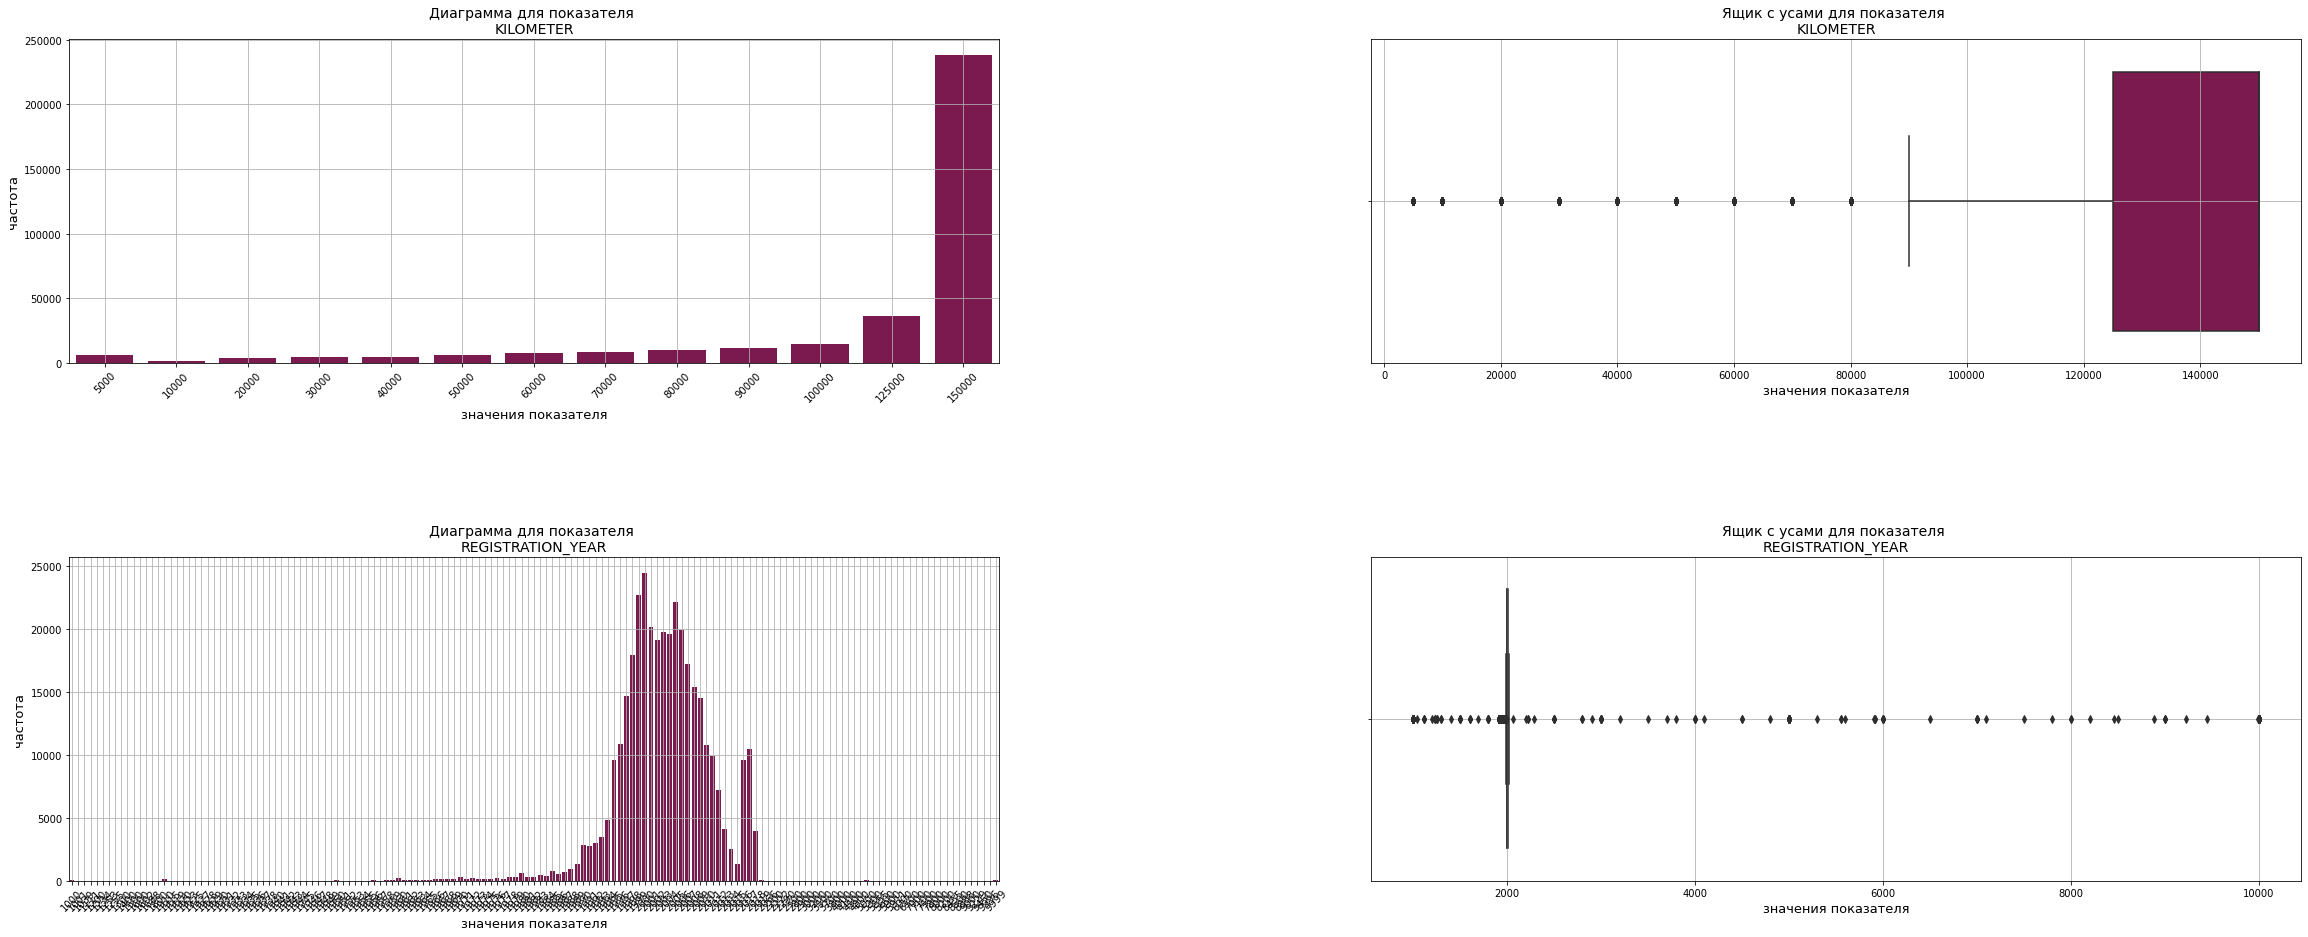

In [37]:
position = 0
plt.figure(figsize=[40,25])
plt.subplots_adjust(wspace=0.4, hspace=0.6)

list = [ 
    'kilometer',
    'registration_year',
]

for name in list:
    position += 1
    
    df1 = data[name]
    plt.subplot(3, 2, position)
    ax = sns.countplot(x = name, data =data, color = '#8B0A50')
    #df1.plot(kind = 'hist', color = 'orchid')
    plt.title(f'Диаграмма для показателя \n{name.upper()}', fontsize=14)
    plt.xlabel('значения показателя', fontsize=13)
    plt.xticks(rotation=45);
    plt.ylabel('частота', fontsize=13)
    plt.grid(True)
      
    position += 1
    df2 = data[name]
    plt.subplot(3, 2, position)
    sns.boxplot(x= df2,color = '#8B0A50')
    plt.title(f'Ящик с усами для показателя \n{name.upper()}', fontsize=14)
    plt.xlabel('значения показателя',fontsize=13 )
    plt.grid(True);

In [38]:
data = data.query('registration_year > 1959 & registration_year < 2017')
data = data.query('power > 50 & power < 500')
data = data.query('price > 100')

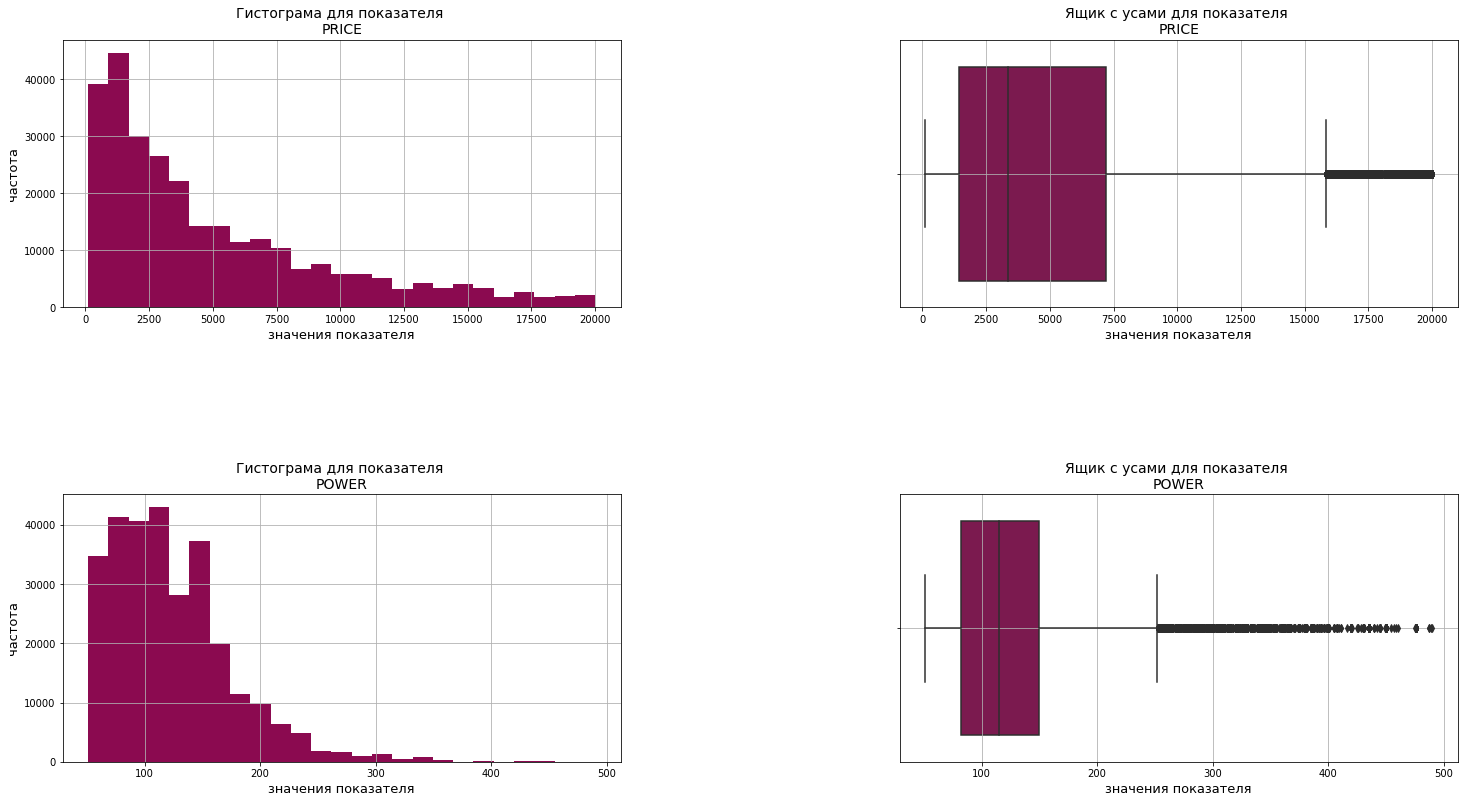

In [39]:
position = 0
plt.figure(figsize=[25,30])
plt.subplots_adjust(wspace=0.5, hspace=0.7)

list = [ 
    'price',
    'power'
]

for name in list:
    position += 1
    
    df1 = data[name]
    plt.subplot(4, 2, position)
    df1.plot(kind = 'hist', color = '#8B0A50', bins = 25)
    plt.title(f'Гистограма для показателя \n{name.upper()}', fontsize=14)
    plt.xlabel('значения показателя', fontsize=13)
    plt.ylabel('частота', fontsize=13)
    plt.grid(True)
    
    position += 1
    df2 = data[name]
    plt.subplot(4, 2, position)
    sns.boxplot(x= df2,color = '#8B0A50')
    plt.title(f'Ящик с усами для показателя \n{name.upper()}', fontsize=14)
    plt.xlabel('значения показателя',fontsize=13 )
    plt.grid(True);

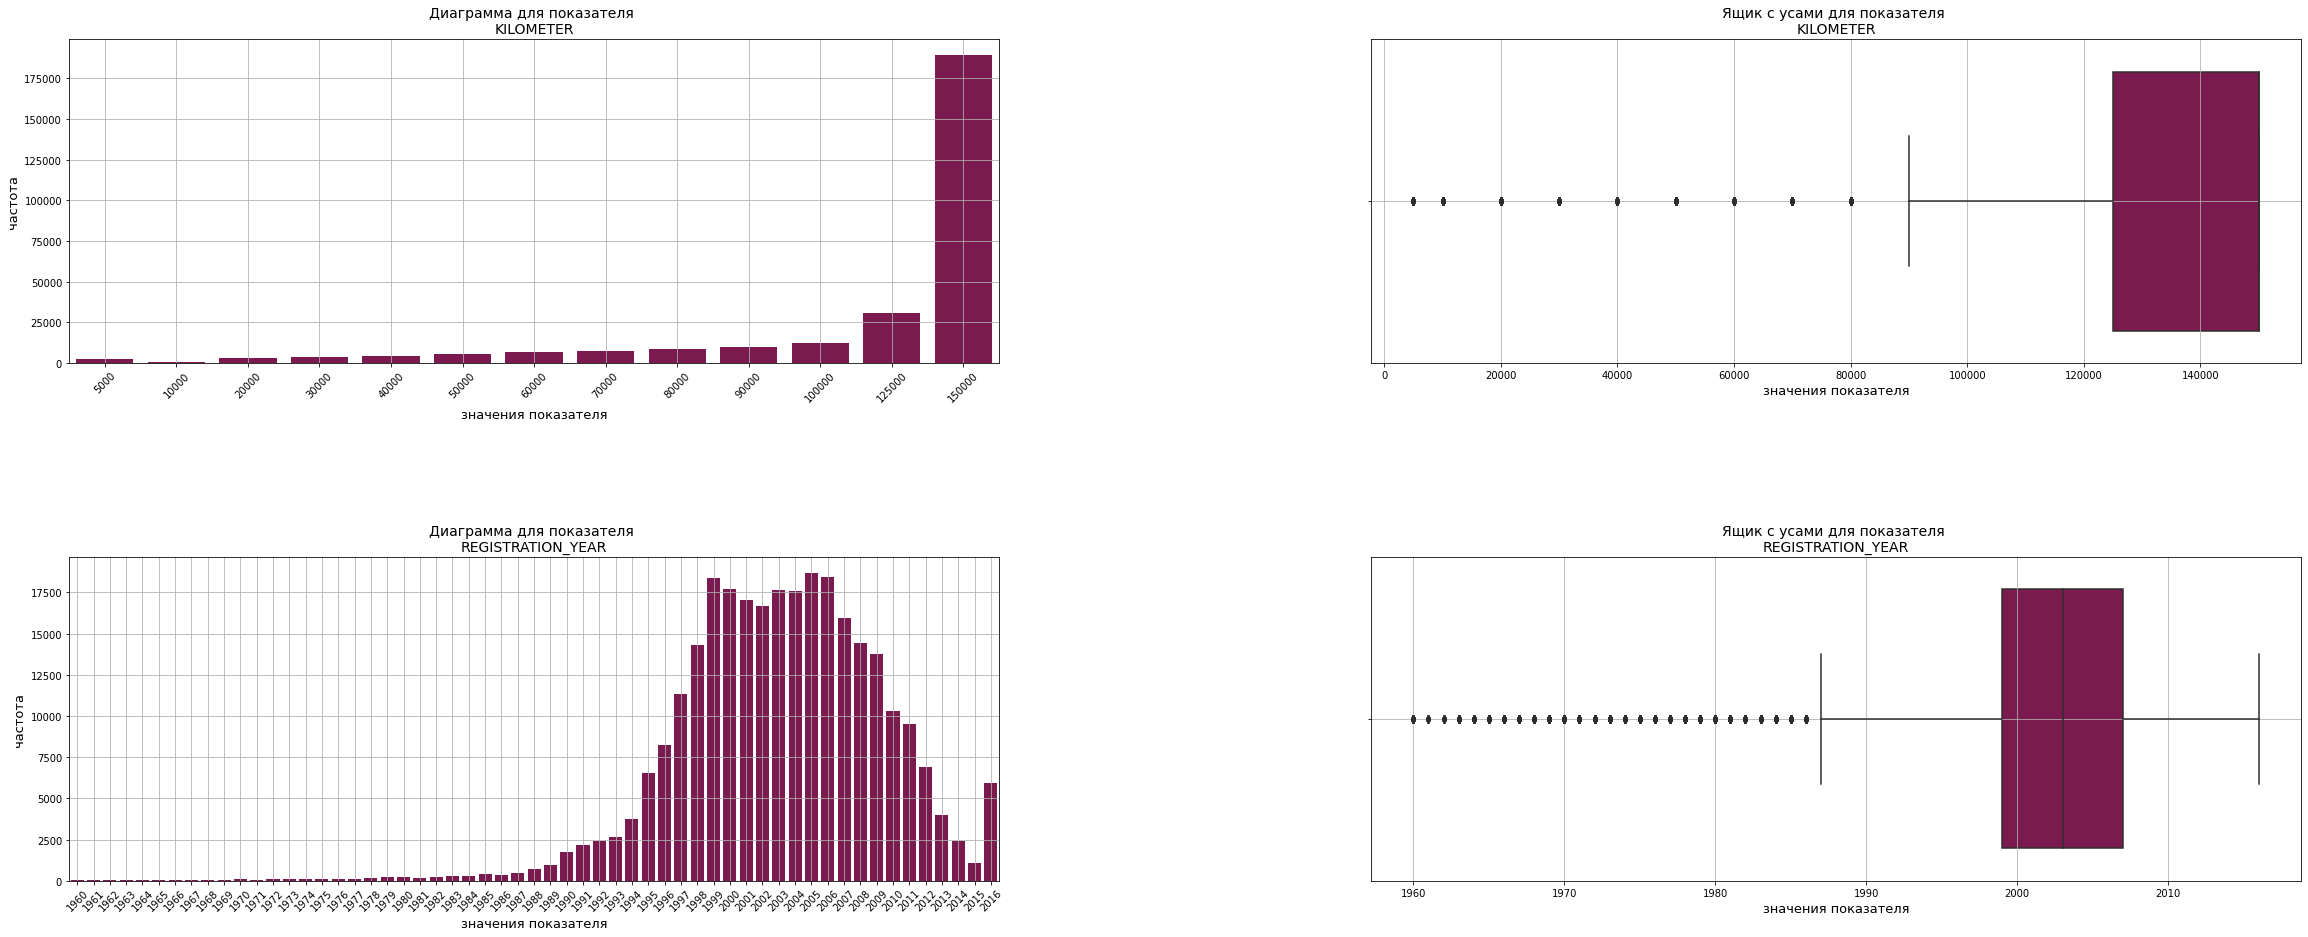

In [40]:
position = 0
plt.figure(figsize=[40,25])
plt.subplots_adjust(wspace=0.4, hspace=0.6)

list = [ 
    'kilometer',
    'registration_year',
]

for name in list:
    position += 1
    
    df1 = data[name]
    plt.subplot(3, 2, position)
    ax = sns.countplot(x = name, data =data, color = '#8B0A50')
    #df1.plot(kind = 'hist', color = 'orchid')
    plt.title(f'Диаграмма для показателя \n{name.upper()}', fontsize=14)
    plt.xlabel('значения показателя', fontsize=13)
    plt.xticks(rotation=45);
    plt.ylabel('частота', fontsize=13)
    plt.grid(True)
      
    position += 1
    df2 = data[name]
    plt.subplot(3, 2, position)
    sns.boxplot(x= df2,color = '#8B0A50')
    plt.title(f'Ящик с усами для показателя \n{name.upper()}', fontsize=14)
    plt.xlabel('значения показателя',fontsize=13 )
    plt.grid(True);

In [41]:
list = [ 
    'price',
    'power',
    'kilometer',
    'registration_year'
]

for name in list:
    df1 = data[name]
    name = list[list.index(name)]
    print(f'Характеристики показателя {name.upper()}')
    print(df1.describe(),'\n')

Характеристики показателя PRICE
count    285082.000000
mean       4984.941550
std        4623.993399
min         101.000000
25%        1450.000000
50%        3350.000000
75%        7200.000000
max       20000.000000
Name: price, dtype: float64 

Характеристики показателя POWER
count    285082.000000
mean        123.169895
std          52.331088
min          51.000000
25%          82.000000
50%         115.000000
75%         150.000000
max         490.000000
Name: power, dtype: float64 

Характеристики показателя KILOMETER
count    285082.000000
mean     128429.732498
std       36570.401126
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: kilometer, dtype: float64 

Характеристики показателя REGISTRATION_YEAR
count    285082.000000
mean       2003.068110
std           6.225566
min        1960.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2016.000000
Name: registration_year, d

<Figure size 1440x5400 with 0 Axes>

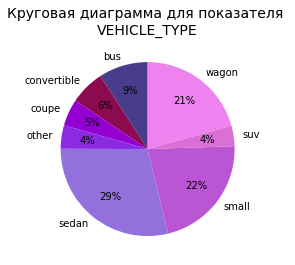

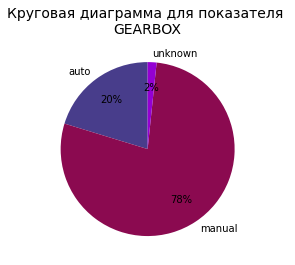

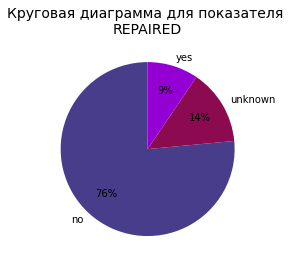

In [42]:
position = 0
plt.figure(figsize=[20,75]);
plt.subplots_adjust(wspace=0.5, hspace=1.0);

list = ['vehicle_type', 'gearbox', 'repaired']


for name in list:
    position += 1
    df1 = data.pivot_table(index = name,values = 'price', aggfunc = 'count')
    df1.plot(
        kind = 'pie',
        subplots=True,
        autopct='%.0f%%',
        colors=['#483D8B','#8B0A50','darkviolet', 'blueviolet', 'mediumpurple', 'mediumorchid', 'orchid', 'violet'],
        startangle=90, 
        pctdistance=0.7
    );
    plt.title(f'Круговая диаграмма для показателя \n{name.upper()}', fontsize=14);
    plt.ylabel("");
    plt.legend().remove();
    plt.show();

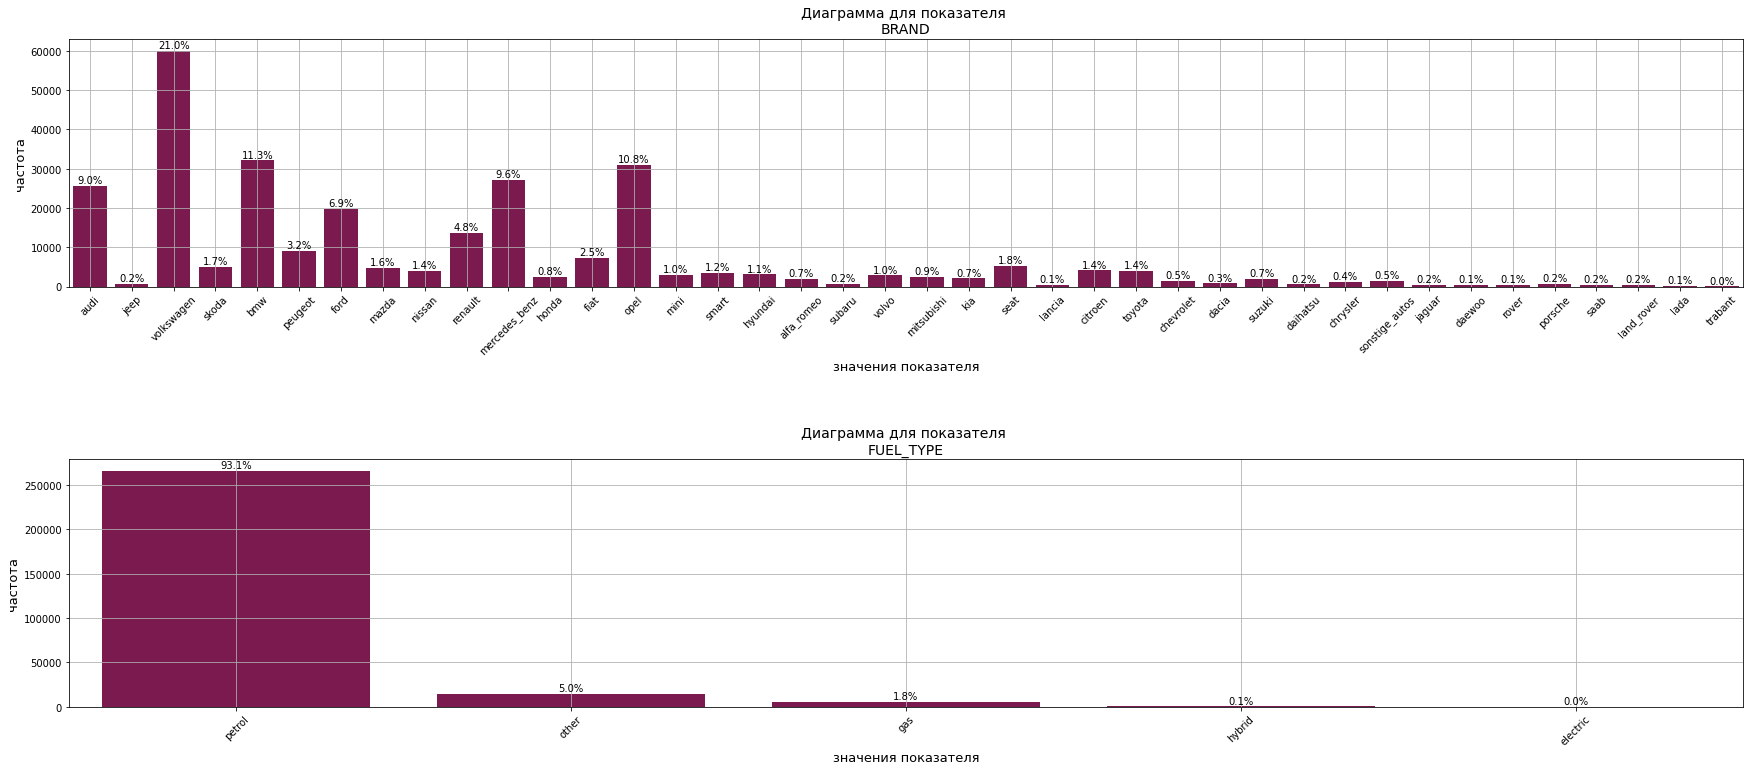

In [43]:
position = 0
plt.figure(figsize=[30,20])
plt.subplots_adjust(wspace=0.5, hspace=0.7)

list = [ 
    'brand',
    'fuel_type'
]

for name in list:
    position += 1
    
    df1 = data[name]
    plt.subplot(3, 1, position)
    ax = sns.countplot(x = name, data =data, color = '#8B0A50')
    #df1.plot(kind = 'hist', color = 'orchid')
    plt.title(f'Диаграмма для показателя \n{name.upper()}', fontsize=14)
    plt.xlabel('значения показателя', fontsize=13)
    plt.ylabel('частота', fontsize=13)
    plt.xticks(rotation=45);
    plt.grid(True)
    
    for p in ax.patches:
        # print(p.get_facecolor(), p.get_label())
        percentage = f'{100 * p.get_height() / len(df1):.1f}%\n'
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()
        ax.annotate(percentage, (x, y), ha='center', va='center')

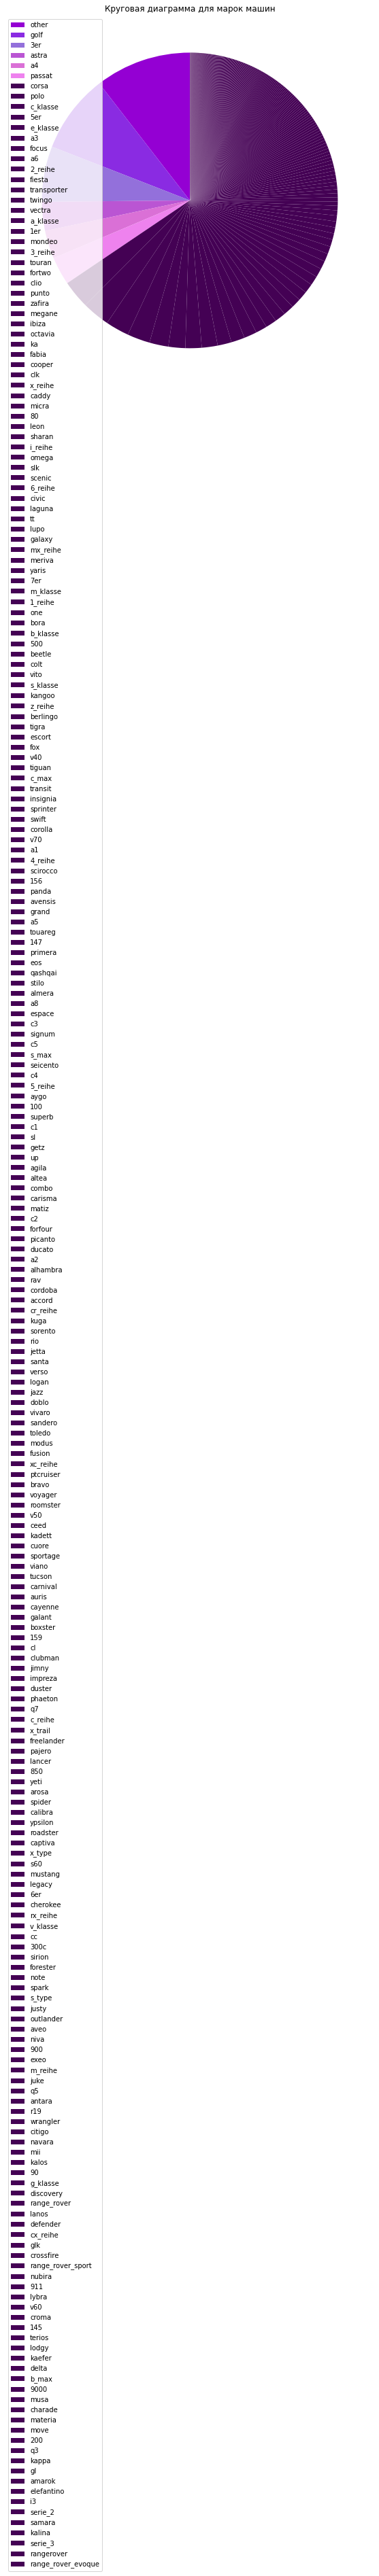

In [44]:
data_2 = data.pivot_table(index = 'model', values = 'price', aggfunc = 'count').sort_values(by = 'price', ascending = False)

colors = sns.color_palette("viridis", len(data))

colors[0] = 'darkviolet'
colors[1] = 'blueviolet'
colors[2] = 'mediumpurple'
colors[3] = 'mediumorchid'
colors[4] = 'orchid'
colors[5] = 'violet'

data_2.plot(
    kind = 'pie',
    subplots=True , 
    startangle=90,
    figsize=(10, 10),
    colors=colors,
    labeldistance=None
)
plt.xlabel("")
plt.ylabel("")
plt.title('Круговая диаграмма для марок машин')
plt.show()

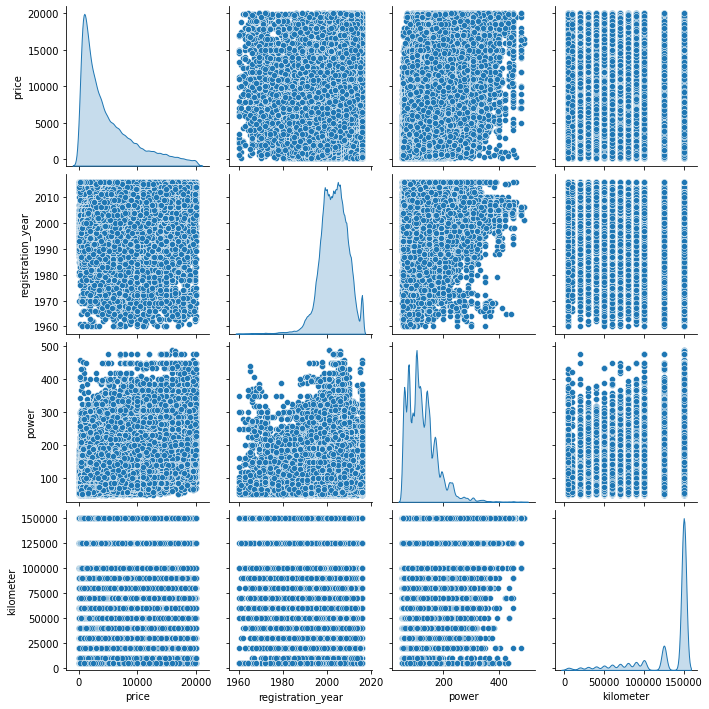

In [45]:
sns.pairplot(data=data, kind='scatter',diag_kind='kde');

interval columns not set, guessing: ['price', 'registration_year', 'power', 'kilometer']


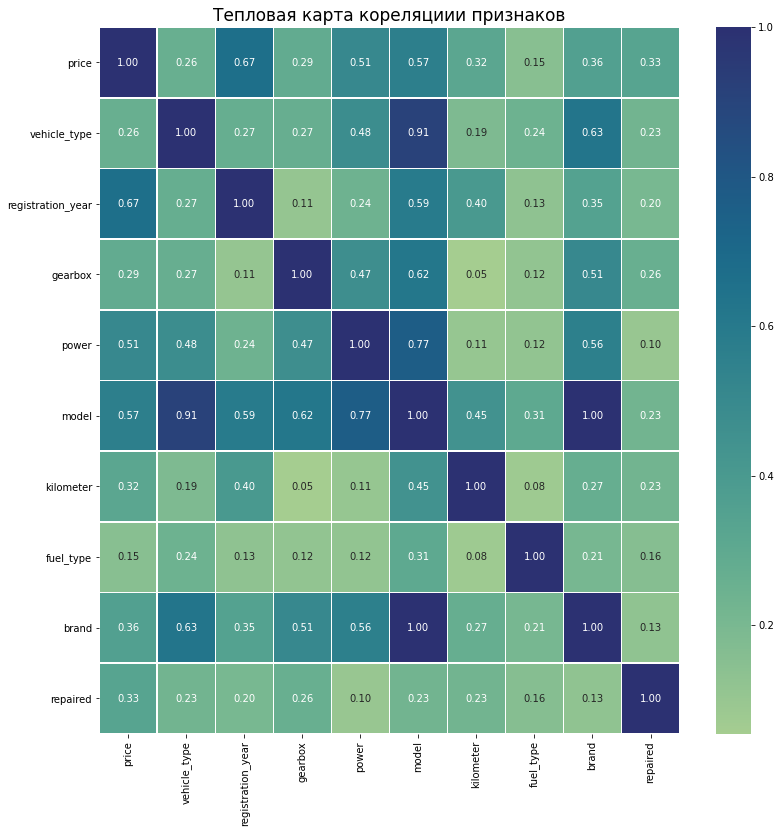

In [46]:
plt.figure(figsize=(13, 13));
sns.heatmap(
    data.phik_matrix()
    ,annot = True
    ,fmt = '.2f'
    ,linewidth=.5
    ,cmap="crest"
);
plt.title('Тепловая карта кореляциии признаков', fontsize=17);

In [47]:
print('Количество дубликотов строк в data :',data.duplicated().sum())
print ('Процент дубликатов строк от всего количества строк',round(data.duplicated().sum() / data.shape[0]* 100,1))
print('Количество строк :',data.shape[0])

Количество дубликотов строк в data : 38156
Процент дубликатов строк от всего количества строк 13.4
Количество строк : 285082


In [48]:
data = data.drop_duplicates()
data = data.reset_index(drop = True)

In [49]:
print(data.shape[0])

246926


In [50]:
#data = data.drop([
   # 'model',
   # 'brand'
#], axis=1)

#### ВЫВОД: 
В ходе исселовательского и кореляционного анализа было установлено:
1. Границы года регистрации: c 1970 по 2016 включительно.
2. Границы мощности: от 50 л.с. до 500 л.с.
3. Границы цены: выше 100 
4. По категориальным данным получается больше всего обьявлении бренда Volkswagen, кузов седан, марка Golf, без ремонта, каробка автомат,тип топливо-бензин.
5. По графику корр. есть высокая корр. между признаками модель и бренд, было принято решение их удалить.

## Обучение моделей
Последние два этапа будут связаны с обучением модели и выявления наиболее выгодной, путем оценки качества предсказания, времени обучения и времени предсказания модели.

In [51]:
features =  data.drop(['price'], axis=1) 
target = data['price']
#features_train, features_test, target_train, target_test = train_test_split(
#    features,target,
#    test_size = TEST_SIZE, 
#    random_state = RANDOM_STATE,
#   )

#features_train.shape[0], features_test.shape[0],target_train.shape[0],target_test.shape[0]

features_train, features_test_valid, target_train, target_test_valid = train_test_split(
    features, target, test_size=0.40, random_state=12345
)
features_test, features_valid, target_test, target_valid = train_test_split(
    features_test_valid, target_test_valid, test_size=0.50, random_state=12345
)
print(
    f'Разделение выборки в следующих пропорциях:\n'
    f'{(len(features_train)/len(data)):.0%} — тренировочная;\n'
    f'{(len(features_test)/len(data)):.0%} — тестовая;\n'
    f'{(len(features_valid)/len(data)):.0%} — валидационная.'
)

Разделение выборки в следующих пропорциях:
60% — тренировочная;
20% — тестовая;
20% — валидационная.


In [52]:
num_columns = [ 'registration_year','power','kilometer']
targ_columns = ['fuel_type','vehicle_type','gearbox','repaired', 'brand','model']

In [53]:
targ_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('targ', TargetEncoder(cv=2, target_type='continuous'))])

In [54]:
data_preprocessor = ColumnTransformer(
    [('targ', targ_pipe, targ_columns),
     ('num', MinMaxScaler(), num_columns)], 
    remainder='passthrough')
data_preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('targ',
                                 Pipeline(steps=[('simpleImputer_ohe',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('targ',
                                                  TargetEncoder(cv=2,
                                                                target_type='continuous'))]),
                                 ['fuel_type', 'vehicle_type', 'gearbox',
                                  'repaired', 'brand', 'model']),
                                ('num', MinMaxScaler(),
                                 ['registration_year', 'power', 'kilometer'])])

In [55]:
models = {
    "LinearRegression": LinearRegression(),
    "LGBMRegressor":LGBMRegressor(random_state=1234, learning_rate=0.5, num_leaves=100),
    "RandomForestRegressor":RandomForestRegressor(random_state=1234, n_estimators=16, max_depth=21)
}    

## Анализ моделей

In [56]:
for name, model in models.items():
    clf = Pipeline([('preprocessor', data_preprocessor),('models',model)])
    
    start_1 = time.time()
    clf.fit(features_train, target_train)
    end_1= time.time()
    fit_time = end_1 - start_1
    
    start_2 = time.time()
    y_pred = clf.predict(features_valid)
    end_2= time.time()
    prediction_time = end_2 - start_2
    
    rmse = mean_squared_error(target_valid, y_pred) ** 0.5
    
    print(f"{name}: fit_time = {fit_time:.2f} s, prediction_time = {prediction_time:.2f} s, rmse = {rmse:.2f}")

LinearRegression: fit_time = 0.44 s, prediction_time = 0.17 s, rmse = 2802.76
LGBMRegressor: fit_time = 5.68 s, prediction_time = 0.40 s, rmse = 1727.27
RandomForestRegressor: fit_time = 7.58 s, prediction_time = 0.34 s, rmse = 1691.21


In [57]:
clf  = Pipeline([('preprocessor', data_preprocessor),('models',RandomForestRegressor(random_state=1234, n_estimators=16, max_depth=21))])    

start_1 = time.time()
clf.fit(features_train, target_train)
end_1= time.time()
fit_time = end_1 - start_1
    
start_2 = time.time()
y_pred = clf.predict(features_test)
end_2= time.time()
prediction_time = end_2 - start_2
    
rmse = mean_squared_error(target_test, y_pred) ** 0.5
    
print(f"RandomForestRegressor: fit_time = {fit_time:.2f} s, prediction_time = {prediction_time:.2f} s, rmse = {rmse:.2f}")

RandomForestRegressor: fit_time = 7.60 s, prediction_time = 0.34 s, rmse = 1709.69


#### ВЫВОД:
Были проанализированы три модели:LinearRegression,LGBMRegressor, RandomForestRegressor.
Модель, у которой метрика < 2500 и лучшее время обучения и предсказания - RandomForestRegressor с параметрами random_state=1234, n_estimators=16, max_depth=21, поскольку имеет лучшую точность и незначительно уступает в оценке времени обучения модели LGBMRegressor.

## ВЫВОД.
Была решена задача по построению модели для определения стоимости.

Критерии задазчика по модели:
- высокое качество предсказания,
- скорость предстазания,
- время обучения.

Для решения задачи было сделано:
1. После выгрузки данных и получения их общей информации было установлено, что в предобрабоке необходимо сделать:
   - исправить название колонн, заменить все буквы на строчные, вместо пробелов "_" ;
   - исправить типы данных, где они установлены некорректно, а именно у DateCrawled, RegistrationMonth,DateCreated, LastSeen.
   - посмотреть все данные на пропуски и дубликаты.
   
   
2. в предобработку данных было выполнено:
   -  удалены столбцы 'date_crawled','registration_month','number_of_pictures','last_seen','date_created','postal_code'. Поскольку информация в них является лишней для нашей задачи.
   - были удалены дубликаты, их было 4.
   -  была проведена замена пропусков, в основном пропуски были заменены на 'other' и 'unknown'.
   
   
3. В ходе исселовательского и кореляционного анализа было установлено:
   - Границы года регистрации: c 1970 по 2016 включительно.
   - Границы мощности: от 50 л.с. до 500 л.с.
   - Границы цены: выше 100 
   - По категориальным данным получается больше всего обьявлении бренда Volkswagen, кузов седан, марка Golf, без ремонта, каробка автомат,тип топливо-бензин.
   - По графику корр. есть высокая корр. между признаками модель и бренд, было принято решение их удалить.
   
   
4. Были проанализированы три модели:LinearRegression,LGBMRegressor, RandomForestRegressor.
Модель, у которой метрика < 2500 и лучшее время обучения и предсказания - RandomForestRegressor с параметрами random_state=1234, n_estimators=16, max_depth=21, поскольку имеет лучшую точность и незначительно уступает в оценке времени обучения модели LGBMRegressor.